# FreshRetailNet-50K Data Exploration

## Learning Objectives
By the end of this notebook, you will understand:
1. The structure and characteristics of the FreshRetailNet-50K dataset
2. Key patterns in retail demand data (seasonality, trends, stockouts)
3. Data quality issues and how to identify them
4. The business context and challenges of fresh retail forecasting

## Business Context

Fresh retail (grocery stores, supermarkets) faces unique challenges:
- **Perishability**: Products have short shelf lives
- **Demand Volatility**: Customer demand varies by hour, day, weather, promotions
- **Stockouts**: When inventory runs out, we lose sales AND can't observe true demand
- **Substitution**: Customers may buy alternatives when their preferred product is unavailable

Understanding these challenges is crucial for building effective forecasting models.

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import our custom modules
import sys
sys.path.append('../src')

from data.data_loader import FreshRetailDataLoader

## 1. Loading the Dataset

Let's start by loading the FreshRetailNet-50K dataset and getting a first look at its structure.

In [2]:
# Initialize data loader
data_loader = FreshRetailDataLoader(
    r'C:\Users\ghald\Documents\FRN50K_ml_prediction_model\config\config.yaml'
)

# Load the data
print("Loading FreshRetailNet-50K dataset...")
train_data, eval_data = data_loader.load_data()

print(f"Training data shape: {train_data.shape}")
print(f"Evaluation data shape: {eval_data.shape}")

Loading FreshRetailNet-50K dataset...
Training data shape: (450000, 19)
Evaluation data shape: (35000, 19)


In [17]:
# Get comprehensive data summary
summary = data_loader.get_data_summary()

print("Dataset Summary:")
for key, value in summary.items():
    print(f"\n{key.upper()}:")
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    else:
        print(f"  {value}")

Dataset Summary:

DATASET_SHAPE:
  train: (450000, 22)
  eval: (35000, 19)

TIME_SPAN:
  start: 2024-03-28 00:00:00
  end: 2024-06-25 00:00:00
  duration_days: 89

BUSINESS_DIMENSIONS:
  unique_stores: 898
  unique_products: 865
  unique_cities: 18
  total_store_product_combinations: 49997

TARGET_STATISTICS:
  mean_sales: 0.994181788888889
  median_sales: 0.7
  zero_sales_percentage: 4.454666666666666
  max_sales: 40.4

STOCKOUT_ANALYSIS:
  total_observations: 450000
  stockout_hours: 8106610
  stockout_rate_percent: 96.19755555555555
  stores_with_stockouts: 898

DATA_QUALITY:
  missing_values: {'city_id': 0, 'store_id': 0, 'management_group_id': 0, 'first_category_id': 0, 'second_category_id': 0, 'third_category_id': 0, 'product_id': 0, 'dt': 0, 'sale_amount': 0, 'hours_sale': 0, 'stock_hour6_22_cnt': 0, 'hours_stock_status': 0, 'discount': 0, 'holiday_flag': 0, 'activity_flag': 0, 'precpt': 0, 'avg_temperature': 0, 'avg_humidity': 0, 'avg_wind_level': 0, 'hour': 0, 'day_of_week': 0

In [18]:
print(train_data[['sale_amount','hours_stock_status']].dtypes)


sale_amount           float64
hours_stock_status     object
dtype: object


## 2. Understanding the Data Structure

Let's examine the columns and data types to understand what information we have available.

In [4]:
# Display basic information about the dataset
print("Column Information:")
print(train_data.info())

print("\nFirst 5 rows:")
train_data.head()

Column Information:
<class 'pandas.DataFrame'>
Index: 450000 entries, 2688763 to 4109294
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   city_id              450000 non-null  int64         
 1   store_id             450000 non-null  int64         
 2   management_group_id  450000 non-null  int64         
 3   first_category_id    450000 non-null  int64         
 4   second_category_id   450000 non-null  int64         
 5   third_category_id    450000 non-null  int64         
 6   product_id           450000 non-null  int64         
 7   dt                   450000 non-null  datetime64[us]
 8   sale_amount          450000 non-null  float64       
 9   hours_sale           450000 non-null  object        
 10  stock_hour6_22_cnt   450000 non-null  int32         
 11  hours_stock_status   450000 non-null  object        
 12  discount             450000 non-null  float64       
 13  hol

,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
2688763,4,832,2,29,76,60,596,2024-04-10,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, ...",4,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000,0,0,1.5019,17.91,77.27,2.08
491106,0,154,6,4,53,58,578,2024-06-02,1.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, ...",9,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",0.908,1,1,1.7640,23.60,69.71,1.52
1774899,0,555,6,8,29,115,99,2024-04-06,1.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.1, ...",5,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.725,1,1,2.8081,17.55,78.55,1.43
1272686,0,309,6,4,28,180,118,2024-06-22,1.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000,1,0,7.9425,27.22,82.12,1.44
4332815,16,546,2,31,79,230,549,2024-05-02,1.3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000,1,0,1.8981,21.43,73.30,1.55


In [5]:
# Let's understand what each column represents
column_descriptions = {
    'city_id': 'Identifier for the city where the store is located',
    'store_id': 'Unique identifier for each store',
    'management_group_id': 'High-level product category grouping',
    'first_category_id': 'Primary product category',
    'second_category_id': 'Secondary product category', 
    'third_category_id': 'Tertiary product category',
    'product_id': 'Unique identifier for each product SKU',
    'dt': 'Date and hour timestamp',
    'sale_amount': 'TARGET VARIABLE - Number of units sold',
    'hours_sale': 'Binary indicator if any sales occurred this hour',
    'stock_hour6_22_cnt': 'Number of hours with stock between 6 AM and 10 PM',
    'hours_stock_status': 'CRITICAL - Stock availability (1=in stock, 0=stockout)',
    'discount': 'Promotional discount percentage',
    'holiday_flag': 'Binary indicator for Chinese statutory holidays',
    'activity_flag': 'Binary indicator for promotional activities',
    'precpt': 'Precipitation (rainfall) in mm',
    'avg_temperature': 'Average temperature in Celsius',
    'avg_humidity': 'Average humidity percentage',
    'avg_wind_level': 'Average wind level'
}

print("Column Descriptions:")
for col, desc in column_descriptions.items():
    if col in train_data.columns:
        print(f"  {col}: {desc}")

Column Descriptions:
  city_id: Identifier for the city where the store is located
  store_id: Unique identifier for each store
  management_group_id: High-level product category grouping
  first_category_id: Primary product category
  second_category_id: Secondary product category
  third_category_id: Tertiary product category
  product_id: Unique identifier for each product SKU
  dt: Date and hour timestamp
  sale_amount: TARGET VARIABLE - Number of units sold
  hours_sale: Binary indicator if any sales occurred this hour
  stock_hour6_22_cnt: Number of hours with stock between 6 AM and 10 PM
  hours_stock_status: CRITICAL - Stock availability (1=in stock, 0=stockout)
  discount: Promotional discount percentage
  holiday_flag: Binary indicator for Chinese statutory holidays
  activity_flag: Binary indicator for promotional activities
  precpt: Precipitation (rainfall) in mm
  avg_temperature: Average temperature in Celsius
  avg_humidity: Average humidity percentage
  avg_wind_level:

## 3. Exploratory Data Analysis

### 3.1 Target Variable Analysis

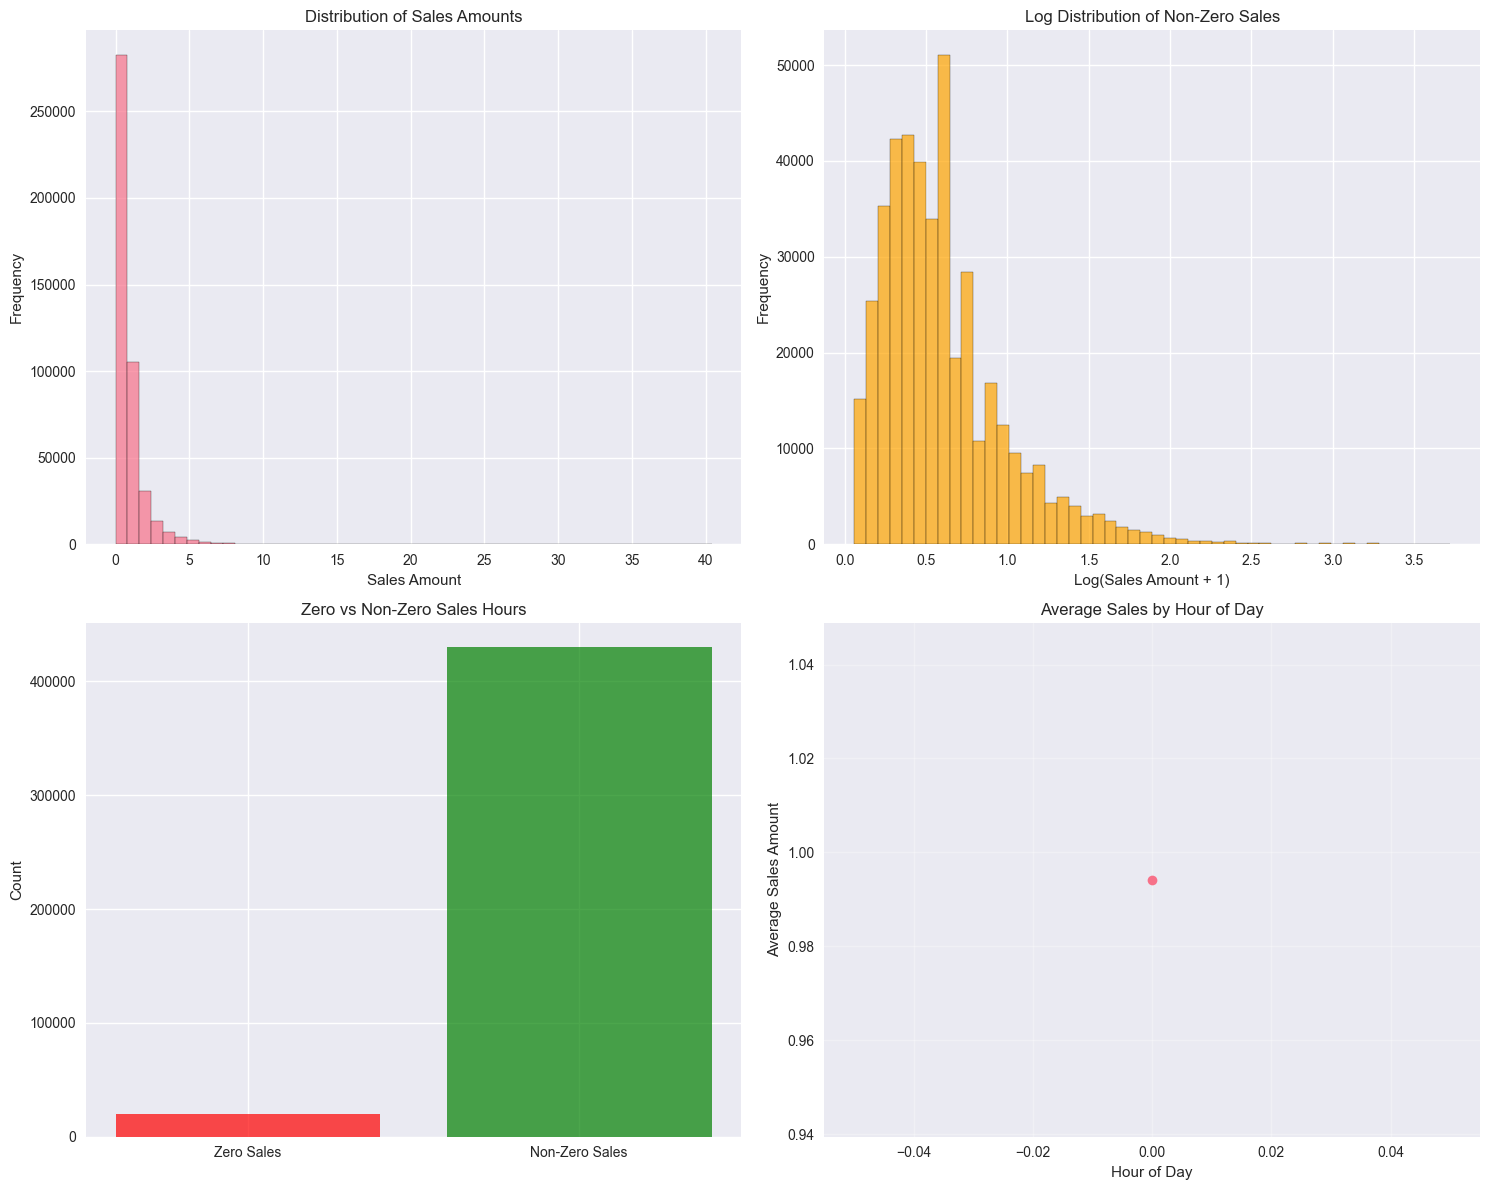

Sales Amount Statistics:
count    450000.000000
mean          0.994182
std           1.384504
min           0.000000
25%           0.400000
50%           0.700000
75%           1.100000
max          40.400000
Name: sale_amount, dtype: float64

Additional Statistics:
Skewness: 8.382368439078363

Zero sales percentage: 4.45%
Maximum sales in one hour: 40.4


In [6]:
# Analyze the target variable (sale_amount)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of sales amounts
axes[0, 0].hist(train_data['sale_amount'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Sales Amounts')
axes[0, 0].set_xlabel('Sales Amount')
axes[0, 0].set_ylabel('Frequency')

# Log-scale distribution (for better visualization of the long tail)
non_zero_sales = train_data[train_data['sale_amount'] > 0]['sale_amount']
axes[0, 1].hist(np.log1p(non_zero_sales), bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].set_title('Log Distribution of Non-Zero Sales')
axes[0, 1].set_xlabel('Log(Sales Amount + 1)')
axes[0, 1].set_ylabel('Frequency')

# Zero vs non-zero sales
zero_sales = (train_data['sale_amount'] == 0).sum()
non_zero_sales = (train_data['sale_amount'] > 0).sum()
axes[1, 0].bar(['Zero Sales', 'Non-Zero Sales'], [zero_sales, non_zero_sales], 
               color=['red', 'green'], alpha=0.7)
axes[1, 0].set_title('Zero vs Non-Zero Sales Hours')
axes[1, 0].set_ylabel('Count')

# Sales amount statistics by hour
hourly_sales = train_data.groupby(train_data['dt'].dt.hour)['sale_amount'].mean()
axes[1, 1].plot(hourly_sales.index, hourly_sales.values, marker='o', linewidth=2)
axes[1, 1].set_title('Average Sales by Hour of Day')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Sales Amount')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
print("Sales Amount Statistics:")
print(train_data['sale_amount'].describe())

print("\nAdditional Statistics:")
print("Skewness:", train_data['sale_amount'].skew())

print(f"\nZero sales percentage: {(train_data['sale_amount'] == 0).mean():.2%}")
print(f"Maximum sales in one hour: {train_data['sale_amount'].max()}")

### 3.2 Time Series Patterns

Understanding temporal patterns is crucial for forecasting. Let's examine daily, weekly, and seasonal patterns.

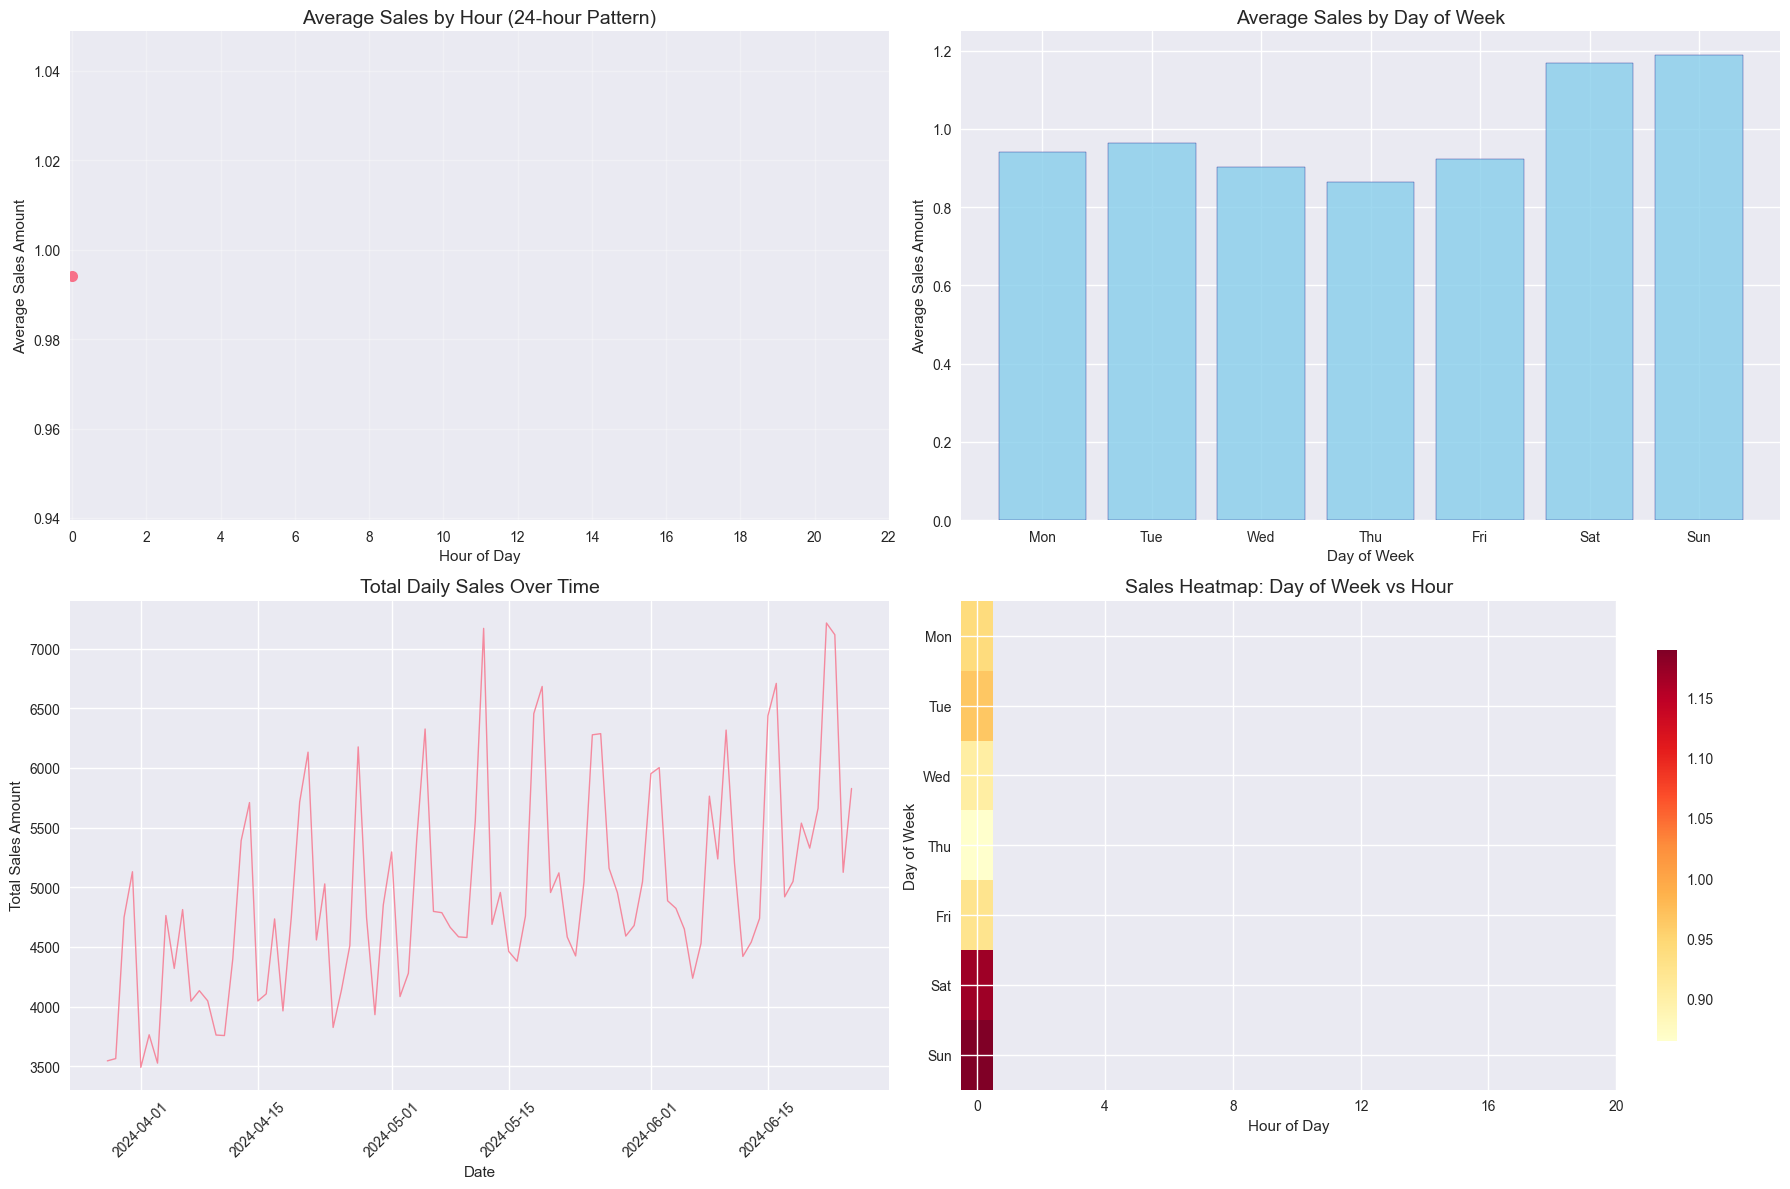


Temporal Pattern Insights:
Peak hour: 0:00 (avg sales: 0.99)
Lowest hour: 0:00 (avg sales: 0.99)
Busiest day: Sun (avg sales: 1.19)
Quietest day: Thu (avg sales: 0.86)


In [7]:
# Analyze time series patterns
train_data['hour'] = train_data['dt'].dt.hour
train_data['day_of_week'] = train_data['dt'].dt.dayofweek  # 0=Monday, 6=Sunday
train_data['date'] = train_data['dt'].dt.date

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Hourly patterns
hourly_pattern = train_data.groupby('hour')['sale_amount'].mean()
axes[0, 0].plot(hourly_pattern.index, hourly_pattern.values, marker='o', linewidth=3, markersize=8)
axes[0, 0].set_title('Average Sales by Hour (24-hour Pattern)', fontsize=14)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Sales Amount')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# Daily patterns (day of week)
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_pattern = train_data.groupby('day_of_week')['sale_amount'].mean()
axes[0, 1].bar(range(7), daily_pattern.values, color='skyblue', alpha=0.8, edgecolor='navy')
axes[0, 1].set_title('Average Sales by Day of Week', fontsize=14)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Sales Amount')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)

# Overall time series (daily aggregation for readability)
daily_sales = train_data.groupby('date')['sale_amount'].sum().reset_index()
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
axes[1, 0].plot(daily_sales['date'], daily_sales['sale_amount'], linewidth=1, alpha=0.8)
axes[1, 0].set_title('Total Daily Sales Over Time', fontsize=14)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Total Sales Amount')
axes[1, 0].tick_params(axis='x', rotation=45)

# Heatmap of hour vs day of week
pivot_data = train_data.groupby(['day_of_week', 'hour'])['sale_amount'].mean().unstack()
im = axes[1, 1].imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('Sales Heatmap: Day of Week vs Hour', fontsize=14)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Day of Week')
axes[1, 1].set_yticks(range(7))
axes[1, 1].set_yticklabels(day_names)
axes[1, 1].set_xticks(range(0, 24, 4))
plt.colorbar(im, ax=axes[1, 1], shrink=0.8)

plt.tight_layout()
plt.show()

# Print insights
print("\nTemporal Pattern Insights:")
print(f"Peak hour: {hourly_pattern.idxmax()}:00 (avg sales: {hourly_pattern.max():.2f})")
print(f"Lowest hour: {hourly_pattern.idxmin()}:00 (avg sales: {hourly_pattern.min():.2f})")
print(f"Busiest day: {day_names[daily_pattern.idxmax()]} (avg sales: {daily_pattern.max():.2f})")
print(f"Quietest day: {day_names[daily_pattern.idxmin()]} (avg sales: {daily_pattern.min():.2f})")

### 3.3 Stockout Analysis

This is the most critical aspect of this dataset - understanding stockouts and their impact on demand.

In [ ]:
# Analyze stockout patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Stockout frequency
stockout_counts = train_data['hours_stock_status'].value_counts()
axes[0, 0].bar(['Stockout', 'In Stock'], [stockout_counts[0], stockout_counts[1]], 
               color=['red', 'green'], alpha=0.7)
axes[0, 0].set_title('Stock Status Distribution')
axes[0, 0].set_ylabel('Number of Hours')

# Sales vs stock status
stock_sales = train_data.groupby('hours_stock_status')['sale_amount'].agg(['mean', 'std', 'count'])
axes[0, 1].bar(['Stockout (0)', 'In Stock (1)'], stock_sales['mean'], 
               yerr=stock_sales['std'], capsize=5, color=['red', 'green'], alpha=0.7)
axes[0, 1].set_title('Average Sales by Stock Status')
axes[0, 1].set_ylabel('Average Sales Amount')

# Stockout patterns by hour
hourly_stockout_rate = train_data.groupby('hour')['hours_stock_status'].apply(lambda x: (x == 0).mean())
axes[1, 0].plot(hourly_stockout_rate.index, hourly_stockout_rate.values * 100, 
                marker='o', linewidth=2, color='red')
axes[1, 0].set_title('Stockout Rate by Hour of Day')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Stockout Rate (%)')
axes[1, 0].grid(True, alpha=0.3)

# Stockout patterns by day of week
daily_stockout_rate = train_data.groupby('day_of_week')['hours_stock_status'].apply(lambda x: (x == 0).mean())
axes[1, 1].bar(range(7), daily_stockout_rate.values * 100, color='orange', alpha=0.7)
axes[1, 1].set_title('Stockout Rate by Day of Week')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Stockout Rate (%)')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)

plt.tight_layout()
plt.show()

# Analyze the relationship between stockouts and zero sales
print("\nStockout Analysis:")
stockout_rate = (train_data['hours_stock_status'] == 0).mean()
print(f"Overall stockout rate: {stockout_rate:.2%}")

# Cross-tabulation of stock status vs sales
crosstab = pd.crosstab(train_data['hours_stock_status'], 
                       train_data['sale_amount'] == 0, 
                       margins=True, normalize='index')
print("\nStock Status vs Zero Sales (row percentages):")
print(crosstab)

# This reveals the "censoring" problem!
zero_sales_when_stocked = crosstab.loc[1, True]  # Zero sales when in stock
zero_sales_when_stockout = crosstab.loc[0, True]  # Zero sales when stockout

print(f"\nKey Insight - The Censoring Problem:")
print(f"When products are IN STOCK, {zero_sales_when_stocked:.1%} of hours have zero sales")
print(f"When products are STOCKED OUT, {zero_sales_when_stockout:.1%} of hours have zero sales")
print(f"This means stockouts systematically create 'false zeros' in our sales data!")